In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import seaborn as sn
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import *
from lib.policy import MarlPPOPolicy
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
from lib.models import FcNN, MyFCNNActorProb, MyFCNNCriticProb
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

# load and look at trained policz

In [3]:
#load trained bolicy to continue training
DUMP_PATH = "dump/Kolmogorov20_ppo_cgs1_fgs1/"
ID = "20241016-092258"
#policy.load_state_dict(torch.load(DUMP_PATH+'policy_'+ID+'.pth'))

with open(DUMP_PATH+'config_'+ID+'.pkl', 'rb') as f:
    args = pickle.load(f)

In [4]:
 #######################################################################################################
####### environments ##################################################################################
#######################################################################################################
seeds = np.array([33])
assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds
val_seeds = seeds
#test_seeds = np.array([69, 33, 420])

train_env = KolmogorovEnvironment20(seeds=train_seeds, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)
test_env = KolmogorovEnvironment20(seeds=val_seeds, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)

Re=10000, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842
Re=10000, m_prime=320400, T=227.00832667993888, omega=1.99437028369627
Re=10000, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842
Re=10000, m_prime=320400, T=227.00832667993888, omega=1.99437028369627


In [5]:
#######################################################################################################
####### Policy ########################################################################################
#######################################################################################################
actor = central_actor_net2(in_channels=2, device=device).to(device)
critic = central_critic_net2(in_channels=2, device=device).to(device)
optim = torch.optim.Adam(actor.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal
policy = PPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=args.gamma,
    reward_normalization=args.reward_normalization, 
    deterministic_eval=True,
    action_scaling=args.action_scaling,
    action_bound_method=args.action_bound_method,
    ent_coef = args.ent_coef,
    vf_coef = args.vf_coef,
    max_grad_norm = args.max_grad_norm,
    gae_lambda=args.gae_lambda, 
)

In [6]:
#load trained bolicy
policy.load_state_dict(torch.load(DUMP_PATH+'policy_'+ID+'.pth'))

<All keys matched successfully>

0.9913306006826363


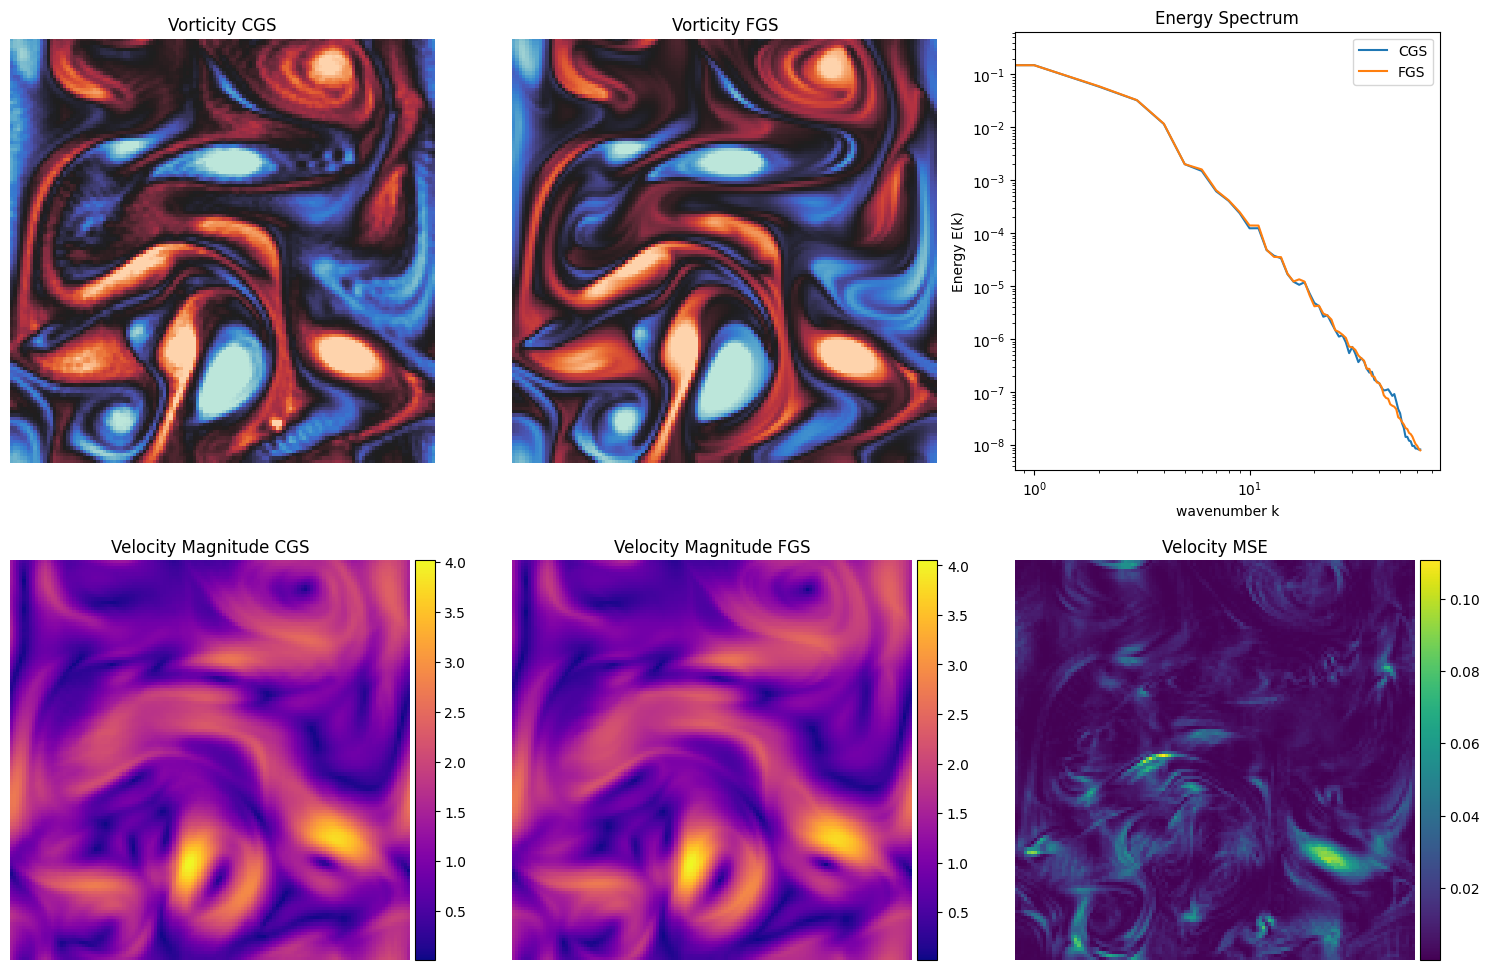

0.946581369946921


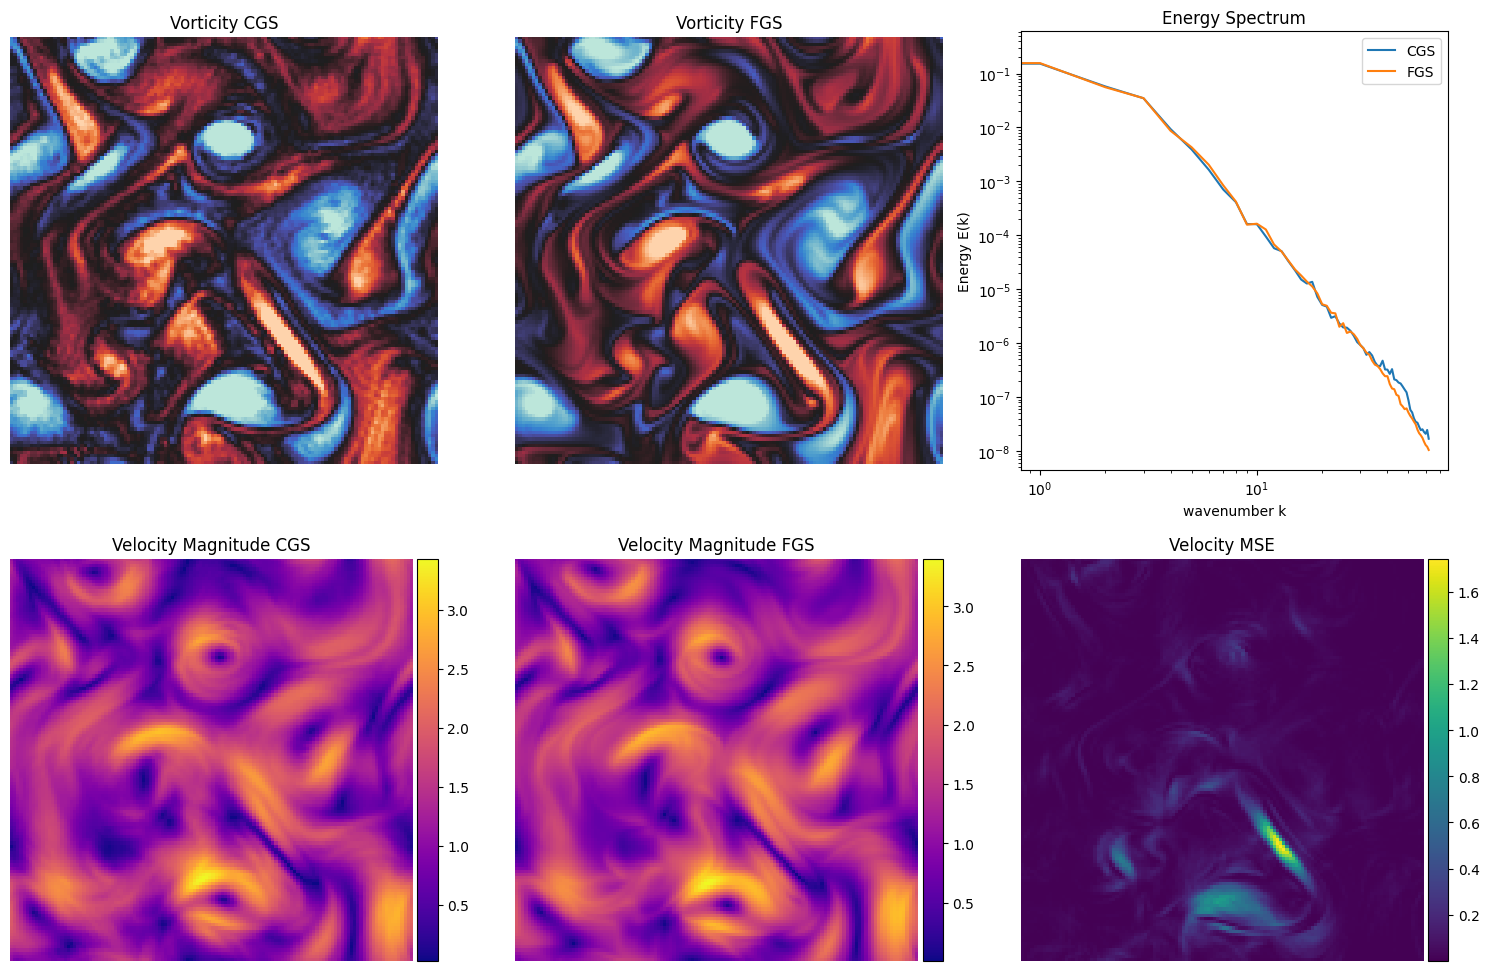

0.8494511668566784


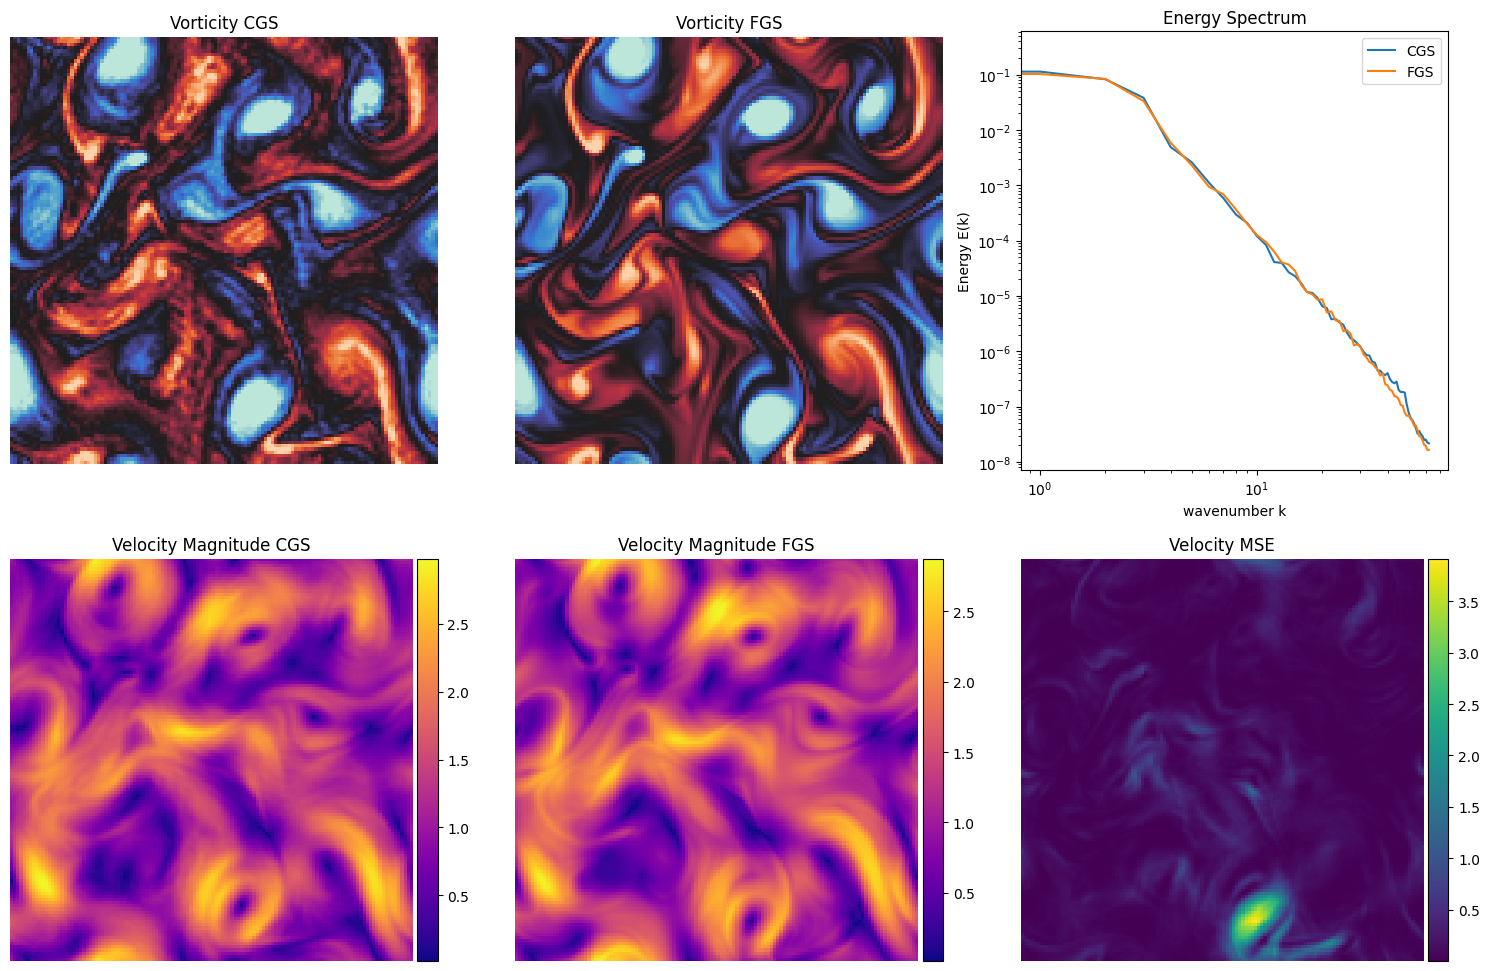

0.5833360495582287


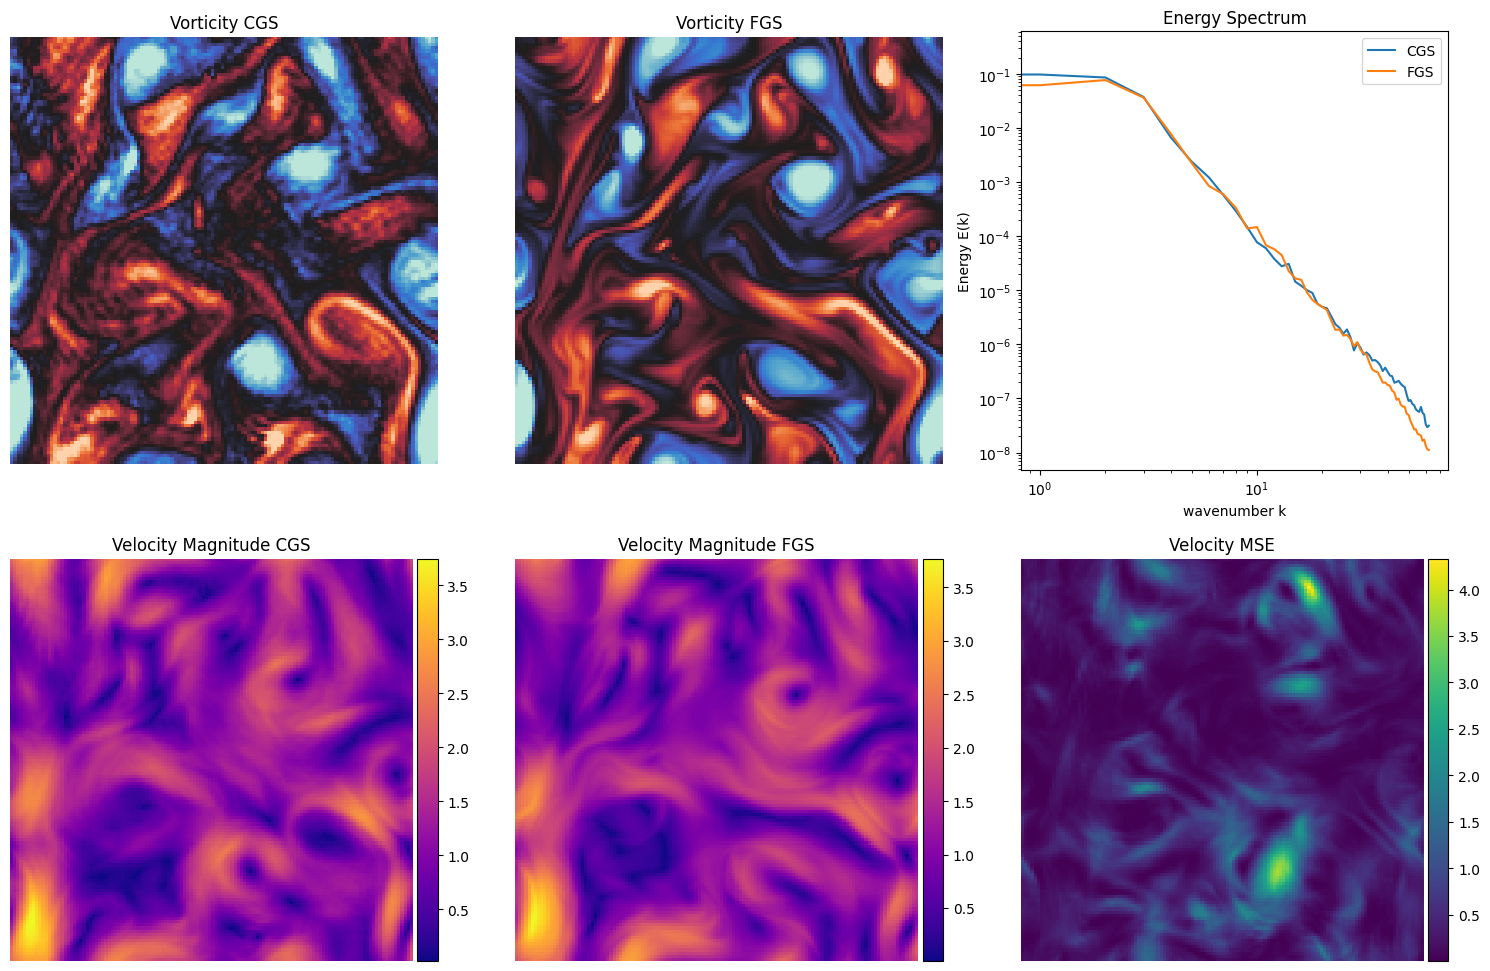

-0.5588548191416995


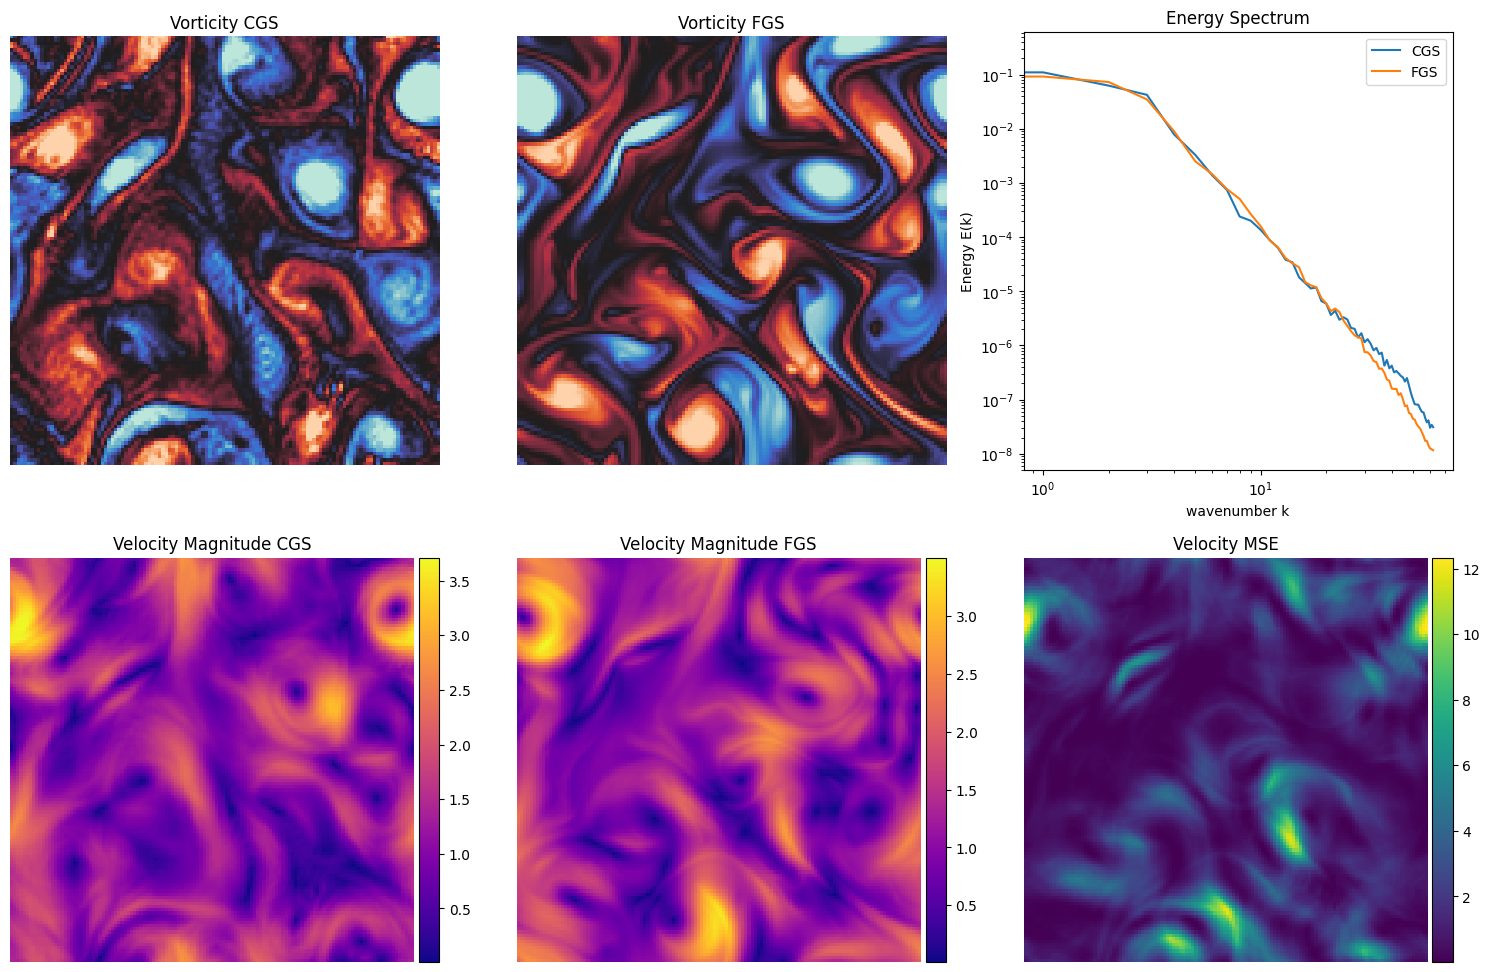

-1.4390592216703446


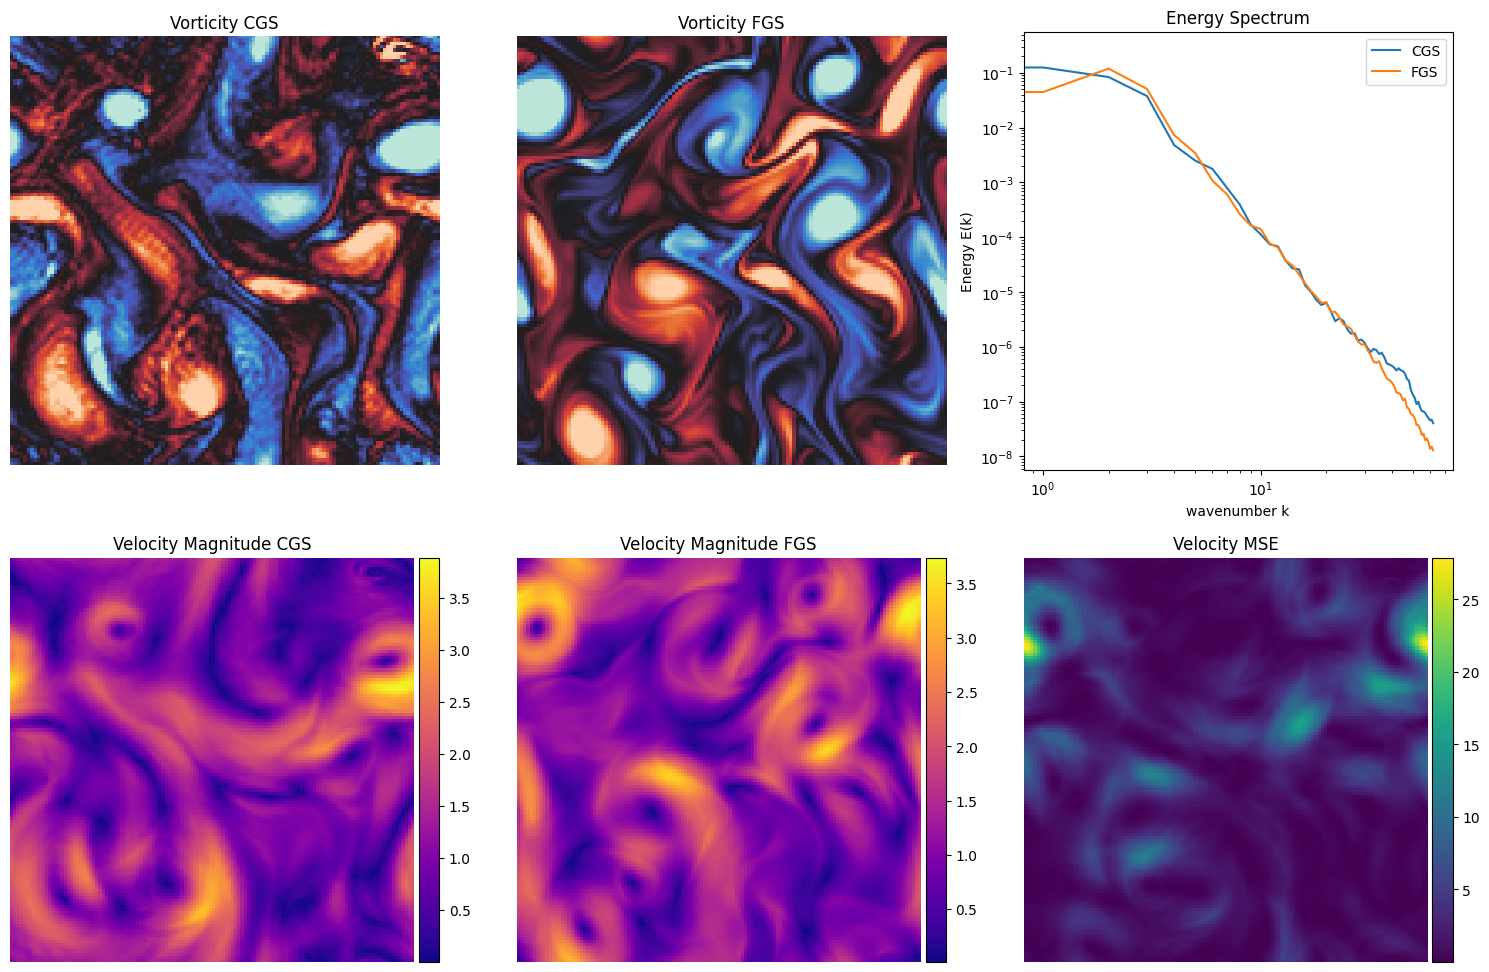

-1.9456567738573134


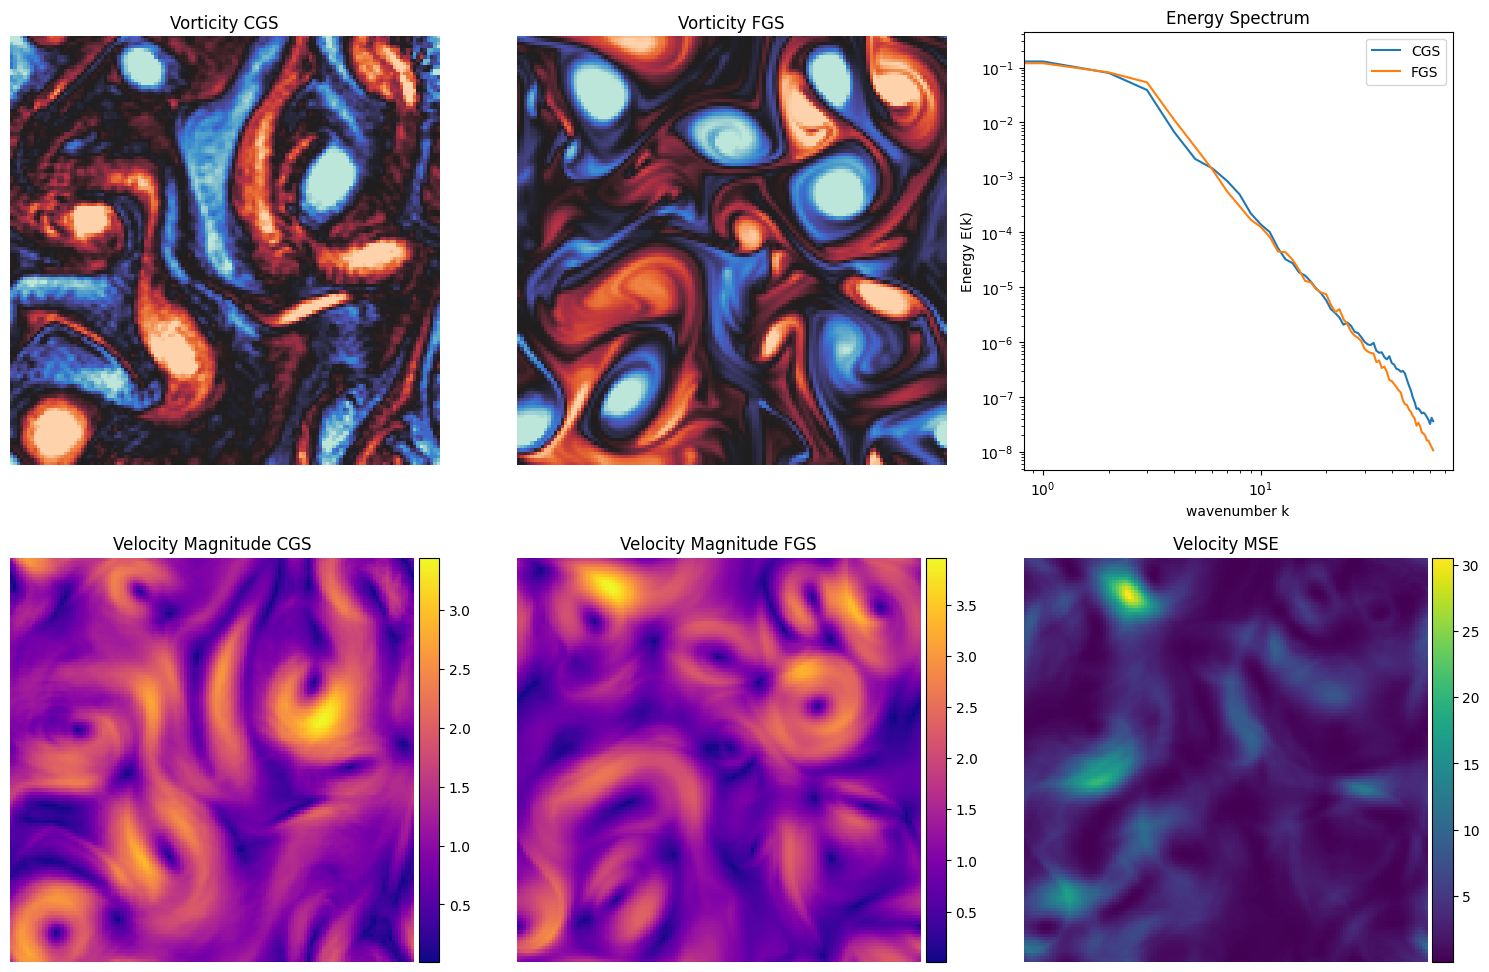

-3.020623996781259


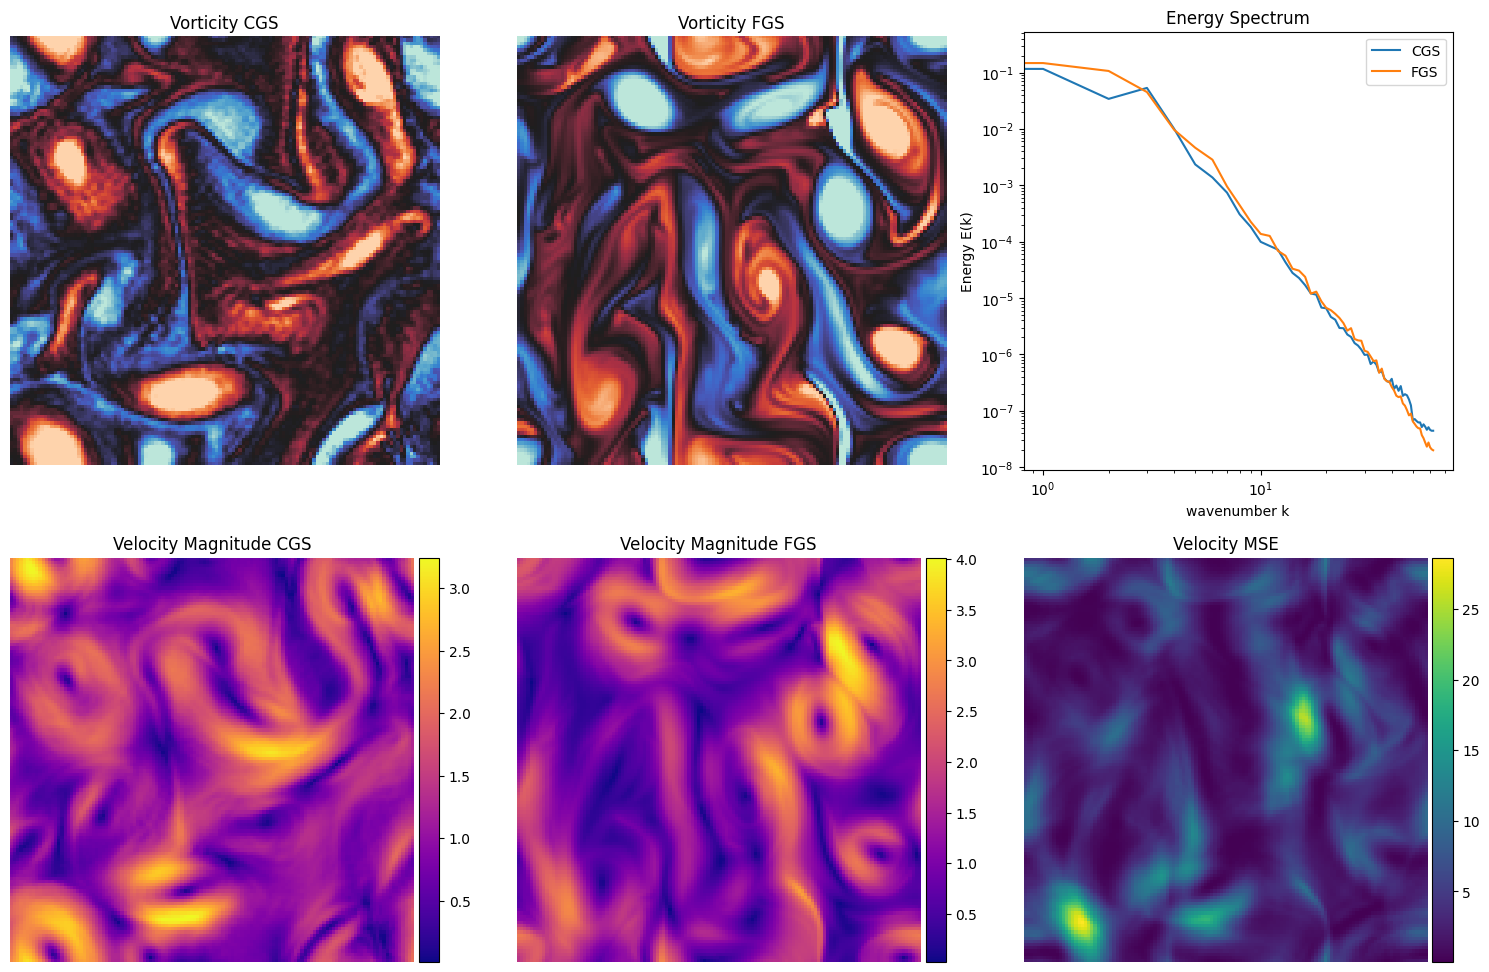

-3.8235453603766985


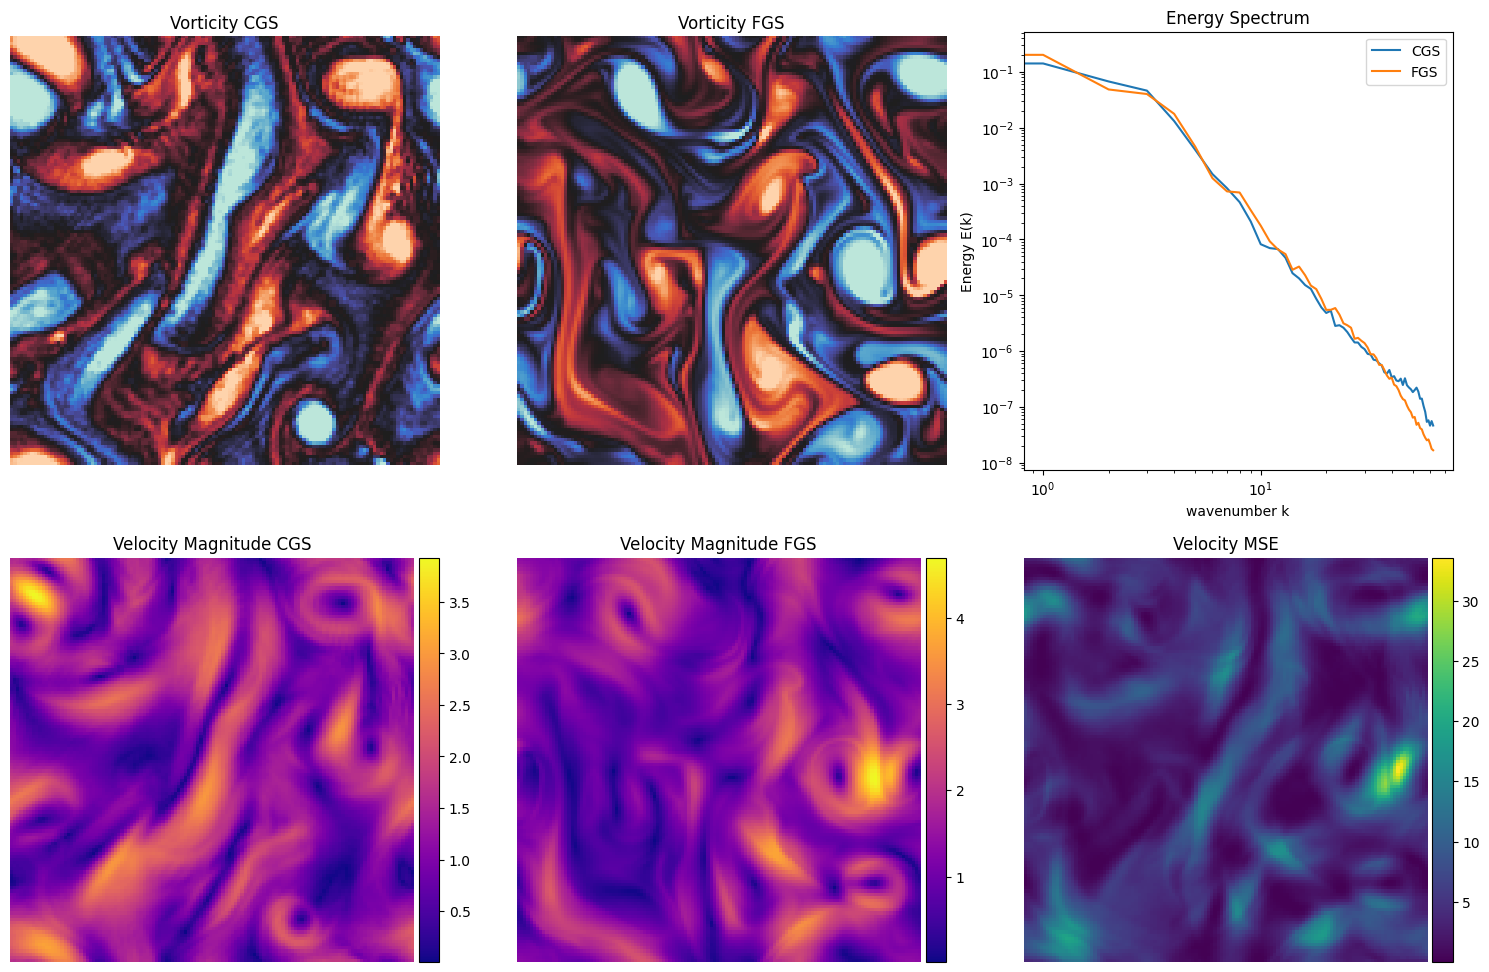

-3.8493412047338404


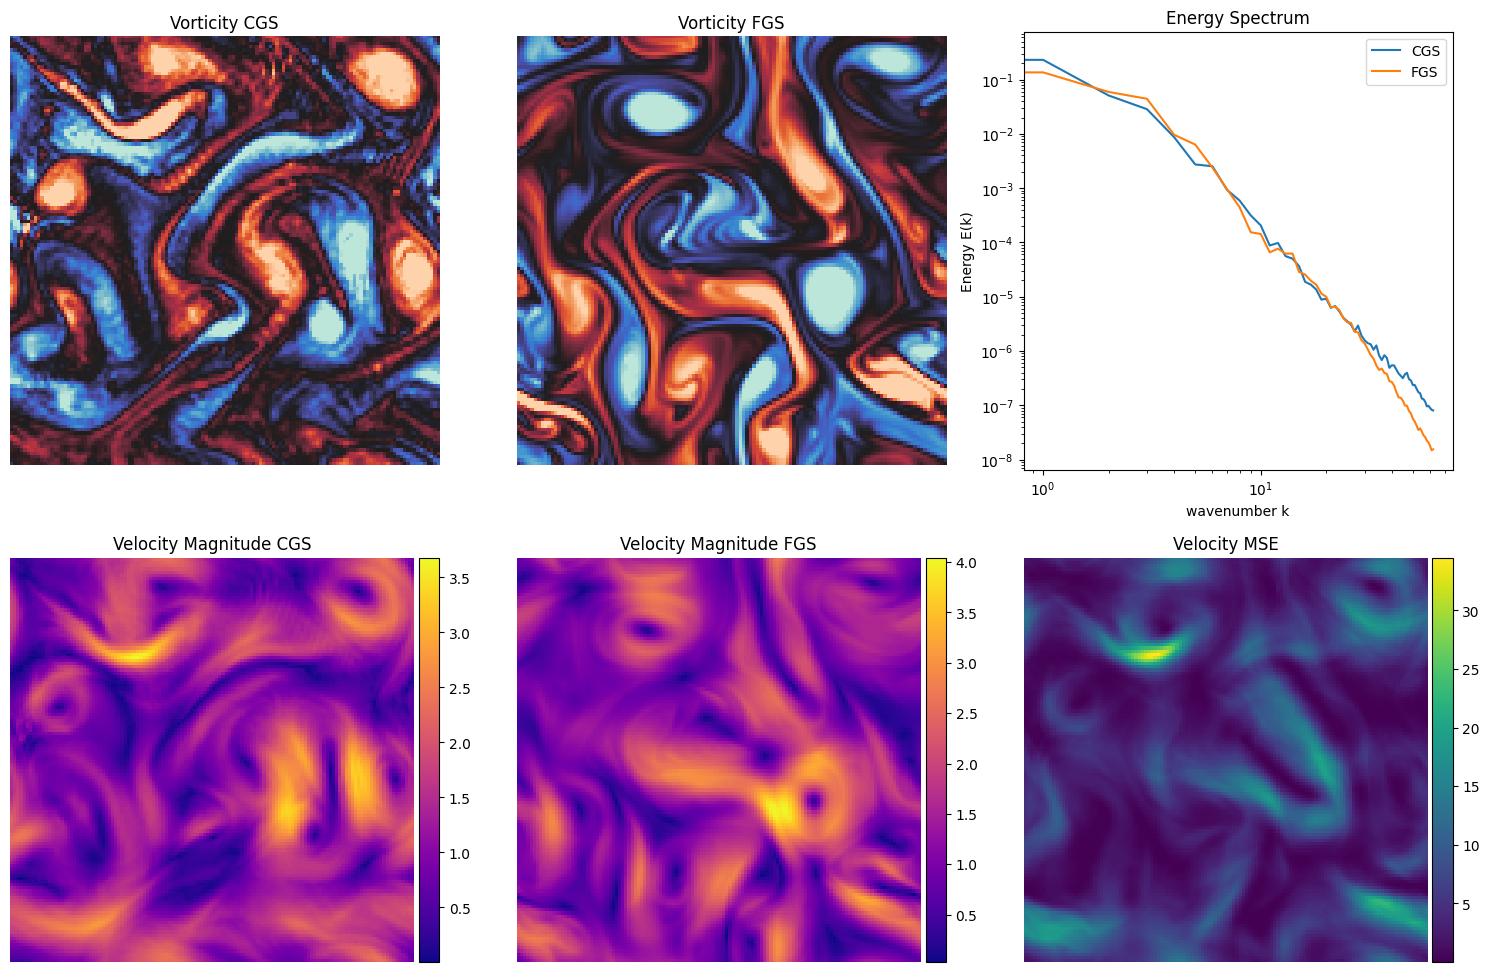

truncated
#steps = 20025, Total Reward = -18317.001100804744


In [7]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
acts = []
trivial_action = np.zeros(train_env.action_space.shape)
episode_is_over = False
act = np.ones(test_env.action_space.shape)
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    #obs, rew, terminated, truncated, inf = test_env.step(trivial_action)
    acts.append(act)
    reward += rew
    step += 1
    if step%2000==0:
        print(rew)
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        #print(f"mean={logits[0].mean()}, std={logits[1].mean()}, act={action.mean()}, scaled act = {act.mean()}")
        #print(f"rew- mean{rew.mean()} +- {rew.std()} in [{rew.min()},{rew.max()}]")
        test_env.render()
        #v = test_env.get_vorticity()
        #plot_policy(logits[0].reshape(128,128), logits[1].reshape(128,128), v)
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

In [7]:
Re = 10000
N = 128 
T = 227
seed = 102
upsi = 1

In [8]:
if not os.path.exists(f"re{int(Re)}_T{int(T)}_N{int(N)}_S{seed}_U{upsi}_dump_policy"):
    os.makedirs(f"re{int(Re)}_T{int(T)}_N{int(N)}_S{seed}_U{upsi}_dump_policy")
os.chdir(f"re{int(Re)}_T{int(T)}_N{int(N)}_S{seed}_U{upsi}_dump_policy")
# remove all .png files in the current directory

In [9]:
!pwd

/home/pfischer/CNN-MARL_closure_model_discovery/re10000_T227_N128_S102_U1_dump_policy


/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [9]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
acts = []
trivial_action = np.zeros(train_env.action_space.shape)
episode_is_over = False
act = np.ones(test_env.action_space.shape)
m = 20026
io_rate = 8
for step in tqdm(range(20026)):
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    #obs, rew, terminated, truncated, inf = test_env.step(trivial_action)
    acts.append(act)
    reward += rew
    if step%io_rate==0:
       #save velocity field as npy
        fname = "klmgrv"
        fname = "velocity_" + fname
        fname = fname + "_" + f"s{102}"
        fname = fname + "_" + str(step).zfill(6)
        u1 = test_env.u1
        np.save(fname, u1)

    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

100%|██████████| 20026/20026 [00:56<00:00, 352.92it/s]


truncated
truncated


AttributeError: 'float' object has no attribute 'mean'

: 

In [17]:
#play one episode of T=227 and save npy files at same frequency as visualizations
print(np.array(acts).mean())
print(np.array(acts).std())

-0.0002274632
0.0


In [ ]:
# trained global action
#steps = 5000, Total Reward = 3959.149094250915
#steps = 1980, Total Reward = 1629.2470463411048
#steps = 1979, Total Reward = 1628.4114643869793
#steps = 495, Total Reward = 321.78269335891486

#trivial action
#steps = 1980, Total Reward = 1522.6651627185977
#steps = 1980, Total Reward = 1522.6651627185977
#steps = 1979, Total Reward = 1622.0979063768702
#steps = 495, Total Reward = 321.72114564304064


In [11]:
np.array(acts).mean()

-0.00022932581

### look at torch distribution

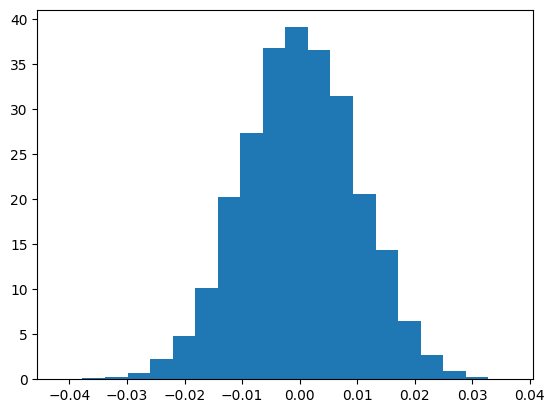

In [94]:
dist = torch.distributions.Normal
samples = np.array([dist(0,0.01).sample() for _ in range(10000)])

plt.figure()
plt.hist(samples, bins=20, density=True)
plt.show()

In [95]:
mean = torch.zeros((1,2,2))
std = torch.ones((1,2,2))
sample = dist(mean,std).sample()
print(sample)
print(dist(mean,std).log_prob(sample))

tensor([[[ 0.5836,  1.0106],
         [ 0.0907, -0.3934]]])
tensor([[[-1.0892, -1.4296],
         [-0.9231, -0.9963]]])


In [96]:
dist2 = ElementwiseNormal
dist2.marl = True
print(dist2(mean,std).log_prob(sample))

tensor([[-1.0892, -1.4296],
        [-0.9231, -0.9963]])


: 

### develop interpolating agents

In [18]:
N_agents = 2
nx = train_env.cgs.nx
ny = train_env.cgs.ny

In [20]:
b = nx/N_agents #distance between agents
coord = np.array([(b//2+i*b, b//2+j*b) for i in range(N_agents) for j in range(N_agents)])
#xx, yy = coord[:, 0], coord[:, 1]

In [28]:
coord

array([[32., 32.],
       [32., 96.],
       [96., 32.],
       [96., 96.]])

In [29]:
grid_x

array([[  0,   1,   2, ..., 125, 126, 127],
       [  0,   1,   2, ..., 125, 126, 127],
       [  0,   1,   2, ..., 125, 126, 127],
       ...,
       [  0,   1,   2, ..., 125, 126, 127],
       [  0,   1,   2, ..., 125, 126, 127],
       [  0,   1,   2, ..., 125, 126, 127]])

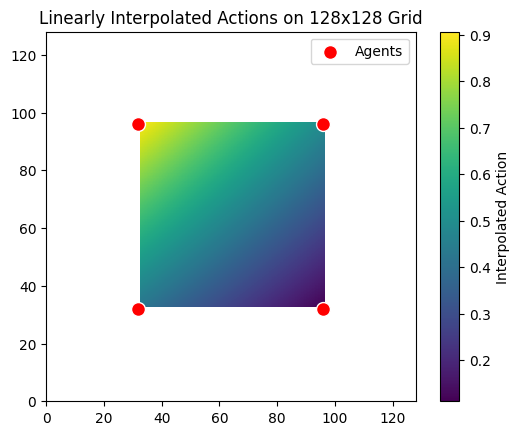

In [42]:
from scipy.interpolate import griddata

# Number of agents and action per agent
N_agents = 2
b = 128 / N_agents  # distance between agents

# Create agent coordinates (for simplicity, assume 2D grid of agents)
coord = np.array([(b//2 + i*b, b//2 + j*b) for i in range(N_agents) for j in range(N_agents)])

# Example actions for each agent (could be random or based on some policy)
actions = np.random.rand(N_agents * N_agents)

# Create grid where we want to interpolate the actions (128x128 grid points)
grid_x, grid_y = np.meshgrid(np.arange(128), np.arange(128))

# Perform linear interpolation using griddata
interpolated_actions = griddata(coord, actions, (grid_x, grid_y), method='cubic')

# Plot the interpolated actions
plt.imshow(interpolated_actions, extent=(0, 128, 0, 128), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Action')
plt.title('Linearly Interpolated Actions on 128x128 Grid')

# Plot agent locations
coord_x, coord_y = coord[:, 0], coord[:, 1]
plt.scatter(coord_x, coord_y, color='red', label='Agents', edgecolor='white', s=100, zorder=5)

# Add legend and show the plot
plt.legend()
plt.show()

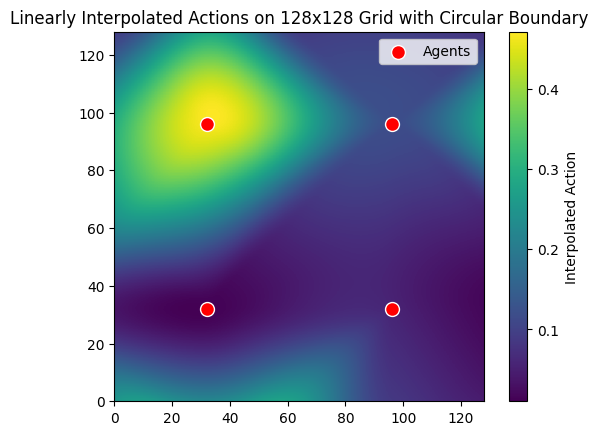

In [43]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Number of agents and action per agent
N_agents = 2
b = 128 / N_agents  # distance between agents

# Create agent coordinates (for simplicity, assume 2D grid of agents)
coord = np.array([(b//2 + i*b, b//2 + j*b) for i in range(N_agents) for j in range(N_agents)])

# Example actions for each agent (could be random or based on some policy)
actions = np.random.rand(N_agents * N_agents)

# Extend coordinates to handle periodic boundary conditions (wrap-around)
extended_coord = []
extended_actions = []

# Extend coordinates and actions in each direction (left, right, top, bottom)
for i in range(-1, 2):
    for j in range(-1, 2):
        extended_coord.append(coord + np.array([i * 128, j * 128]))
        extended_actions.append(actions)

extended_coord = np.vstack(extended_coord)
extended_actions = np.hstack(extended_actions)

# Create grid where we want to interpolate the actions (128x128 grid points)
grid_x, grid_y = np.meshgrid(np.arange(128), np.arange(128))

# Perform linear interpolation using griddata
interpolated_actions = griddata(extended_coord, extended_actions, (grid_x, grid_y), method='cubic')

# Plot the interpolated actions
plt.imshow(interpolated_actions, extent=(0, 128, 0, 128), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Action')
plt.title('Linearly Interpolated Actions on 128x128 Grid with Circular Boundary')

# Plot agent locations
coord_x, coord_y = coord[:, 0], coord[:, 1]
plt.scatter(coord_x, coord_y, color='red', label='Agents', edgecolor='white', s=100, zorder=5)

# Add legend and show the plot
plt.legend()
plt.show()


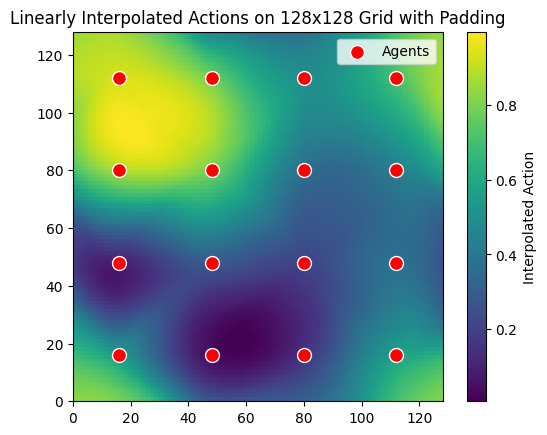

In [49]:

# Number of agents and action per agent
N_agents = 4
b = 128 / N_agents  # distance between agents

# Create agent coordinates (for simplicity, assume 2D grid of agents)
coord = np.array([(b//2 + i*b, b//2 + j*b) for i in range(N_agents) for j in range(N_agents)])

# Example actions for each agent (could be random or based on some policy)
actions = np.random.rand(N_agents * N_agents)

# Define padding size (half of the agent spacing)
padding_size = b / 2

# Extend coordinates to handle padding (add a buffer zone)
padded_coord = []
padded_actions = []

for i in [-1, 0, 1]:
    for j in [-1, 0, 1]:
        shift = np.array([i * 128, j * 128])
        padded_coord.append(coord + shift)
        padded_actions.append(actions)

# Convert extended coordinates and actions into arrays
padded_coord = np.vstack(padded_coord)
padded_actions = np.hstack(padded_actions)

# Create grid with padding for interpolation (from -padding to 128+padding)
padded_grid_x, padded_grid_y = np.meshgrid(np.linspace(-padding_size, 128 + padding_size, 128),
                                           np.linspace(-padding_size, 128 + padding_size, 128))

# Perform linear interpolation on the padded grid
interpolated_actions_padded = griddata(padded_coord, padded_actions, (padded_grid_x, padded_grid_y), method='cubic')

# Crop the result to the original grid size (remove padding)
interpolated_actions = interpolated_actions_padded[int(padding_size):-int(padding_size), int(padding_size):-int(padding_size)]

# Plot the interpolated actions
plt.imshow(interpolated_actions, extent=(0, 128, 0, 128), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Action')
plt.title('Linearly Interpolated Actions on 128x128 Grid with Padding')

# Plot agent locations
coord_x, coord_y = coord[:, 0], coord[:, 1]
plt.scatter(coord_x, coord_y, color='red', label='Agents', edgecolor='white', s=100, zorder=5)

# Add legend and show the plot
plt.legend()
plt.show()


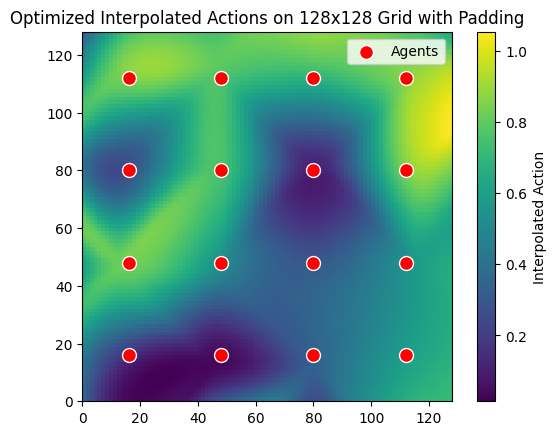

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Number of agents and action per agent
N_agents = 4
b = 128 / N_agents  # distance between agents

# Create agent coordinates (for simplicity, assume 2D grid of agents)
coord = np.array([(b//2 + i*b, b//2 + j*b) for i in range(N_agents) for j in range(N_agents)])

# Example actions for each agent (could be random or based on some policy)
actions = np.random.rand(N_agents * N_agents)

# Define padding size (half of the agent spacing)
padding_size = b / 2

# Efficiently create padded coordinates using broadcasting
shifts = np.array([[i * 128, j * 128] for i in [-1, 0, 1] for j in [-1, 0, 1]])
padded_coord = (coord[:, None, :] + shifts).reshape(-1, 2)

# Efficiently repeat actions for padded coordinates
padded_actions = np.tile(actions, len(shifts))

# Precompute grid for interpolation (from -padding to 128+padding)
padded_grid_x, padded_grid_y = np.meshgrid(
    np.linspace(-padding_size, 128 + padding_size, 128),
    np.linspace(-padding_size, 128 + padding_size, 128)
)

# Perform cubic interpolation on the padded grid
interpolated_actions_padded = griddata(
    padded_coord, padded_actions, (padded_grid_x, padded_grid_y), method='cubic'
)

# Crop the result to the original grid size (remove padding)
interpolated_actions = interpolated_actions_padded[int(padding_size):-int(padding_size), int(padding_size):-int(padding_size)]

# Plot the interpolated actions
plt.imshow(interpolated_actions, extent=(0, 128, 0, 128), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Action')
plt.title('Optimized Interpolated Actions on 128x128 Grid with Padding')

# Plot agent locations
coord_x, coord_y = coord[:, 0], coord[:, 1]
plt.scatter(coord_x, coord_y, color='red', label='Agents', edgecolor='white', s=100, zorder=5)

# Add legend and show the plot
plt.legend()
plt.show()


### look at pressure-tensor

In [7]:
f1 = train_env.f1
c = train_env.cgs.lattice.c
u1 = train_env.u1
rho1 = train_env.rho1
C_u = train_env.cgs.C_u

In [8]:
#check if moments match
if not np.any(f1.sum(axis=-1) != rho1.squeeze(-1)):
    print("first moment matches")

if np.all(np.isclose(u1,(f1 @ c.T /(rho1*C_u)), rtol=1e-3)):
    print("second moment matches")


first moment matches
second moment matches


In [9]:
c_a = c[0,:]
c_b = c[1,:]
f = f1[0,0,:]

In [ ]:
# compute 2nd moment
P_11 = c_a @ (c_a * f)
P_12 = c_a @ (c_b * f)
P_21 = c_b @ (c_a * f)
P_22 = c_b @ (c_b * f)

P = np.array([[P_11, P_12], 
             [P_21, P_22]])

print(P)

# this is appoximately the same:
print(c @ (c.T * f.reshape(-1,1)))

[[ 0.33402537 -0.0007951 ]
 [-0.0007951   0.33335337]]
[[ 0.33402537 -0.0007951 ]
 [-0.0007951   0.33335337]]


In [11]:
P = np.einsum('ni,...n,nj->...ij', c.T, f1, c.T)
P = P/rho1[:, :, np.newaxis]
print(P[0,0,...])
print(P.mean(axis=(0,1)))
print(P.std(axis=(0,1)))

[[ 0.33381933 -0.0007946 ]
 [-0.0007946   0.33314775]]


In [13]:
feq = train_env.cgs.equilibrium(rho1, u1, cast_output=False)
fneq = f1 - feq
momentum_flux = train_env.cgs.momentum_flux(fneq)
print(momentum_flux.shape)
print(momentum_flux[0,0,:])
print(momentum_flux.mean(axis=(0,1)))
print(momentum_flux.std(axis=(0,1)))

(128, 128, 3)
[-0.00593921  0.10008741 -1.5840732 ]
[-1.1962084  -0.06554564 -0.91726332]
[1.6005042  1.18311864 1.12492184]


In [14]:
P_neq = np.einsum('ni,...n,nj->...ij', c.T, fneq, c.T)

In [16]:
print(P_neq.shape)
print(P_neq[0,0,...])
print(P_neq.mean(axis=(0,1)))
print(P_neq.std(axis=(0,1)))

(128, 128, 2, 2)
[[-0.00593921  0.10008741]
 [ 0.10008741 -1.5840732 ]]
[[-1.1962084  -0.06554564]
 [-0.06554564 -0.91726332]]
[[1.6005042  1.18311864]
 [1.18311864 1.12492184]]


In [27]:
np.concatenate((rho1, u1, momentum_flux), axis=-1)

(128, 128, 6)

In [22]:
rho1.shape

(128, 128, 1)

In [24]:
u1.shape

(128, 128, 2)

In [25]:
momentum_flux.shape

(128, 128, 3)